# Example preprocessing notebook

In this notebook we are going to walk through a single patient example. There are probably some patient-specific stuff in here that might change with other patients. Should be able to demonstrate the usage of different functions from the toolbox.

1. Load raw data (.edf in this notebook) using mne

2. Add in electrode information

3. Notch filter line noise and cleaning out bad channels 

4. Re-reference the data 


Must read guides: 

https://www.sciencedirect.com/science/article/pii/S1053811922005559


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers

In [3]:
import sys
sys.path.append('/Users/christinamaher/Documents/Github/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
subject = 'MS030'

## Load raw data (.edf in this notebook) using mne

It's a good idea to setup a sensible directory structure like below. Note that all my data lives on '/sc/arion' which is Minerva. 


mne: https://mne.tools/stable/index.html

In [6]:
base_dir = '/Users/christinamaher/Desktop/fellowship_data' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/{subject}/Ephys'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/{subject}/Behavior'
neural_dir = f'{base_dir}/{subject}/Ephys'
anat_dir = f'{base_dir}/{subject}/Anat'
edf_files = glob(f'{neural_dir}/*.edf')

load the electrophysiology data

In [7]:
mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)

Extracting EDF parameters from /Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/MS030.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1797055  =      0.000 ...  1754.937 secs...


In [8]:
mne_data.ch_names

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOPO1',
 'LmOPO2',
 'LmOPO3',
 'LmOPO4',
 'LmOPO5',
 'LmOPO6',
 'LmOPO7',
 'LmOPO8',
 'LmOPO9',
 'LCMmF1',
 'LCMmF2',
 'LCMmF3',
 'LCMmF4',
 'LCMmF5',
 'LCMmF6',
 'LCMmF7',
 'LCMmF8',
 'LCMmF9',
 'LCMmF10',
 'LCMmF11',
 'LCMmF12',
 'LCMmF13',
 'LCMmF14',
 'LCMmF15',
 'LCMmF16',
 'LsIPT1',
 'LsIPT2',
 'LsIPT3',
 'LsIPT4',
 'LsIPT5',
 'LsIPT6',
 'LsIPT7',
 'LsIPT8',
 'LpIPO1',
 'LpIPO2',
 'LpIPO3',
 'LpIPO4',
 'LpIPO5',
 'LpIPO6',
 'LpIPO7',
 'LpIPO8',
 'C64',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LpISM1',
 'LpISM2',
 'LpISM3',
 'LpISM4',
 'LpISM5',

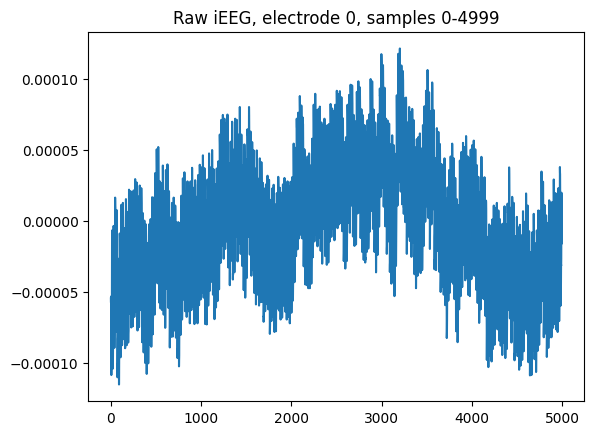

In [9]:
# Sanity check
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

In [10]:
mne_data.ch_names

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOPO1',
 'LmOPO2',
 'LmOPO3',
 'LmOPO4',
 'LmOPO5',
 'LmOPO6',
 'LmOPO7',
 'LmOPO8',
 'LmOPO9',
 'LCMmF1',
 'LCMmF2',
 'LCMmF3',
 'LCMmF4',
 'LCMmF5',
 'LCMmF6',
 'LCMmF7',
 'LCMmF8',
 'LCMmF9',
 'LCMmF10',
 'LCMmF11',
 'LCMmF12',
 'LCMmF13',
 'LCMmF14',
 'LCMmF15',
 'LCMmF16',
 'LsIPT1',
 'LsIPT2',
 'LsIPT3',
 'LsIPT4',
 'LsIPT5',
 'LsIPT6',
 'LsIPT7',
 'LsIPT8',
 'LpIPO1',
 'LpIPO2',
 'LpIPO3',
 'LpIPO4',
 'LpIPO5',
 'LpIPO6',
 'LpIPO7',
 'LpIPO8',
 'C64',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LpISM1',
 'LpISM2',
 'LpISM3',
 'LpISM4',
 'LpISM5',

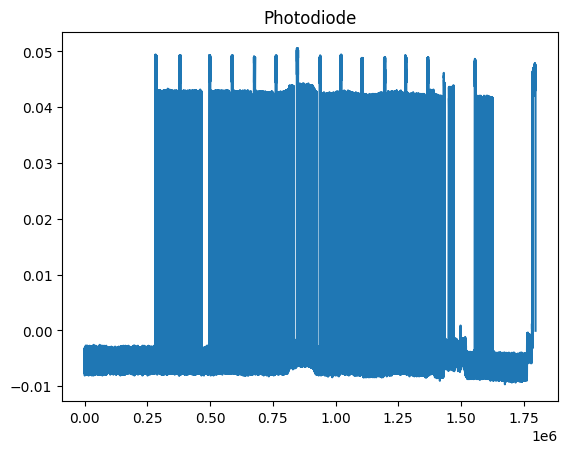

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('DC1') # either named DC1 or Research
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
# Save out the photodiode channel separately
mne_data.save(f'{save_dir}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/photodiode.fif
Closing /Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/photodiode.fif
[done]


/var/folders/5p/bctklsps5kgb5fk5s1nygs3m0000gn/T/ipykernel_1087/4027119453.py:2: RuntimeWarning: This filename (/Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{save_dir}/photodiode.fif', picks='DC1', overwrite=True)


## Add in electrode information

In [13]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/{subject}_labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

In [14]:
elec_locs

,X.2,X.1,X,NMMlabel,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes,bin
0,1,1,1,LaCaS1,A32sg_L,-6.386112,38.974624,12.529659,-6.778861,29.725621,-10.464666,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus C,GM,NaN,acc
1,2,2,2,LaCaS2,A24rv_L,-6.386112,39.374364,17.322032,-6.875897,32.262463,-5.282710,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,GM,NaN,acc
2,3,3,3,LaCaS3,A32sg_L,-6.386112,40.173843,22.513769,-6.814746,35.303751,0.166405,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,WM,NaN,NaN
3,4,4,4,LaCaS4,A32sg_L,-6.386112,40.573583,27.705506,-6.747162,37.927777,5.774297,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,GM,NaN,acc
4,5,5,5,LaCaS5,A32p_L,-6.785244,41.373063,32.497879,-7.088346,40.719284,10.822374,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,GM,NaN,acc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,128,128,128,LsIPT6,A44v_L,-50.689779,19.387377,25.708684,-53.847567,16.199871,12.962351,White,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,WM,NaN,NaN
128,129,129,129,LsIPT7,A44v_L,-55.080232,20.586596,26.507413,-58.757549,17.231126,13.255615,Gray,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,GM,NaN,NaN
129,130,130,130,LsIPT8,Unknown,-59.869818,22.985034,28.104871,-64.018796,19.634418,13.941256,Unknown,Unknown,Area 45,Unknown,Unknown,Unknown,OOB,NaN,NaN
130,131,131,131,uLAgIt,mAmyg_L,-19.557472,16.988938,-11.032842,-20.656646,-1.544513,-27.097992,Gray,Left Ent entorhinal area,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,GM,NaN,amygdala


The electrode names read out of the edf file do not always match those 
in the pdf (used for localization). This could be error on the side of the tech who input the labels, 
or on the side of MNE reading the labels in. Usually there's a mixup between lowercase 'l' and capital 'I'.

Sometimes, there's electrodes on the pdf that are NOT in the MNE data structure... let's identify those as well. 


In [15]:

new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.NMMlabel)

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [16]:
new_mne_names

['lacas1',
 'lacas2',
 'lacas3',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas7',
 'lacas8',
 'lacas9',
 'lacas10',
 'lacas11',
 'lacas12',
 'lmcms1',
 'lmcms2',
 'lmcms3',
 'lmcms4',
 'lmcms5',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'lmcms9',
 'lmcms10',
 'lmoporb1',
 'lmoporb2',
 'lmoporb3',
 'lmoporb4',
 'lmoporb5',
 'lmoporb6',
 'lmoporb7',
 'lmoporb8',
 'lmoporb9',
 'lcmmf1',
 'lcmmf2',
 'lcmmf3',
 'lcmmf4',
 'lcmmf5',
 'lcmmf6',
 'lcmmf7',
 'lcmmf8',
 'lcmmf9',
 'lcmmf10',
 'lcmmf11',
 'lcmmf12',
 'lcmmf13',
 'lcmmf14',
 'lcmmf15',
 'lcmmf16',
 'lsipt1',
 'lsipt2',
 'lsipt3',
 'lsipt4',
 'lsipt5',
 'lsipt6',
 'lsipt7',
 'lsipt8',
 'lpipo1',
 'lpipo2',
 'lpipo3',
 'lpipo4',
 'lpipo5',
 'lpipo6',
 'lpipo7',
 'lpipo8',
 'c64',
 'lagit1',
 'lagit2',
 'lagit3',
 'lagit4',
 'lagit5',
 'lagit6',
 'lagit7',
 'lagit8',
 'lagit9',
 'lhpit1',
 'lhpit2',
 'lhpit3',
 'lhpit4',
 'lhpit5',
 'lhpit6',
 'lhpit7',
 'lhpit8',
 'lhpit9',
 'lhpit10',
 'lhpit11',
 'lhpit12',
 'lpism1',
 'lpism2',
 'lpism3',
 'l

So we retun a new list of channel names for the mne data structure as well as a list of channels in the localization csv which are not found in the mne structure. Make sure that unmatched_seeg does not factor into any referencing schemes later - it's not in the MNE data

In [17]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS030.edf, 276 x 1797056 (1754.9 s), ~3.70 GB, data loaded>

In [18]:
#mne_data.drop_channels(['research']) # only if the photodiode is called research

In [19]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]

print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 130 sEEG electrodes


In [20]:
# you may have errors here if the photodiode channel is called 'research' vs dc1
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}

# Drop random chans? 
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))

In [21]:
mne_data.drop_channels(drop_chans)

<RawEDF | MS030.edf, 130 x 1797056 (1754.9 s), ~1.74 GB, data loaded>

In [22]:
# Set channel types:
mne_data.set_channel_types(sEEG_mapping_dict)

<RawEDF | MS030.edf, 130 x 1797056 (1754.9 s), ~1.74 GB, data loaded>

## Notch filter line noise and cleaning out bad channels 


We want to remove the line noise (60 Hz and harmonics in US data, 50 Hz and harmonics in EU data). 

To do so, we use a band-stop filter that removes a narrow band of frequencies. 

Maybe eventually we don't want to use filters, especially if interested in ERPs: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456018/

In [23]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    4.2s finished


<RawEDF | MS030.edf, 130 x 1797056 (1754.9 s), ~1.74 GB, data loaded>

In [24]:
#all patients should be resampled to 500 Hz
resample_sr = 500 # patients start at 1024 Hz
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    5.8s finished


<RawEDF | MS030.edf, 130 x 877469 (1754.9 s), ~870.4 MB, data loaded>

Denote bad channels - manual only

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


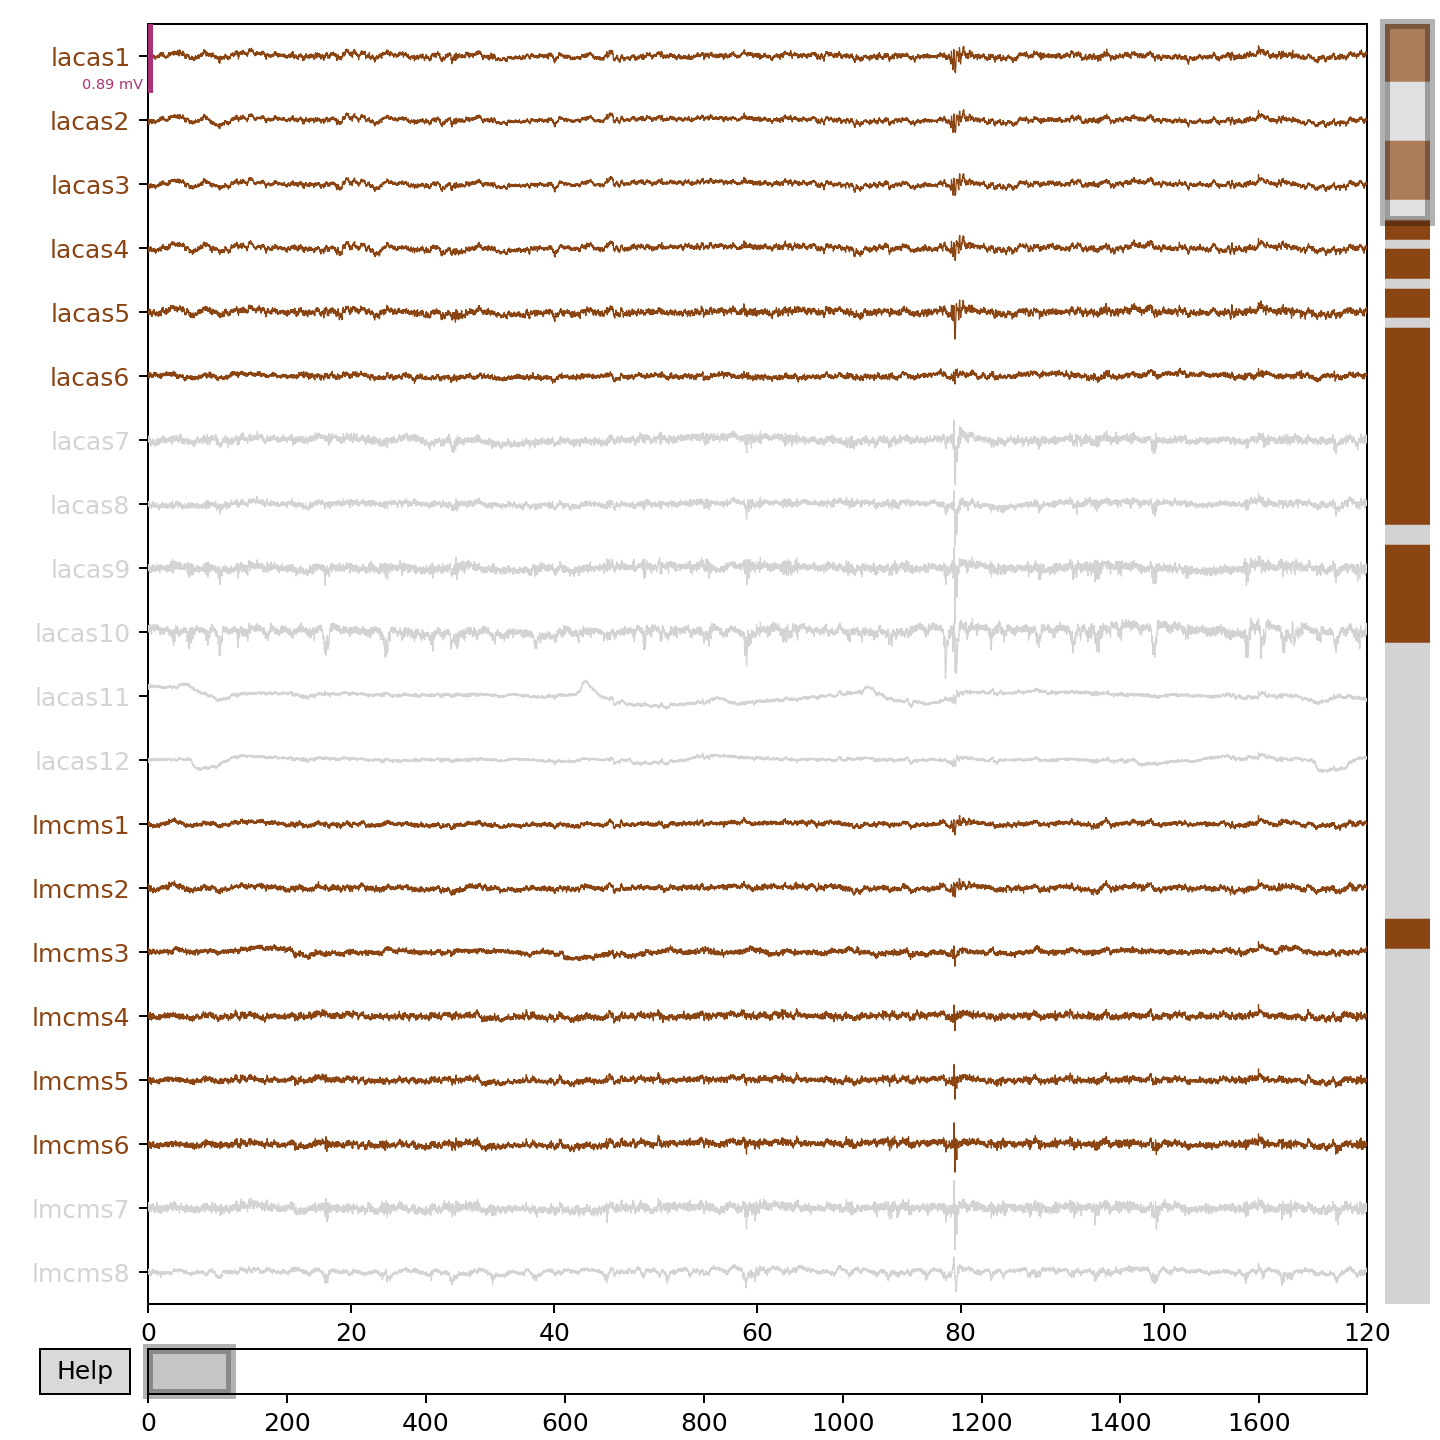

<IPython.core.display.Javascript object>


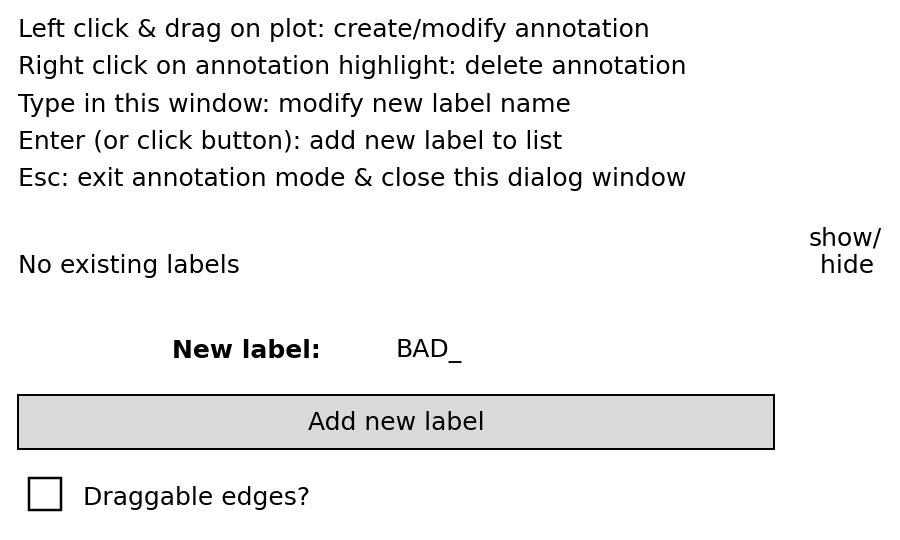

In [25]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=20, scalings=mne_data._data.max()/20) #
fig.fake_keypress('a')

In [26]:
len(mne_data.info['bads'])

77

## Re-reference the data

If you're like me, you find the concept of re-referencing somewhat confusing. Isn't the data recorded relative to a ground and reference in the EMU (https://ahleighton.github.io/OE-ephys-course/EEA/theoryday3.html)? 

It is, but we do digital re-referencing of the recorded signal to clean up any remaining shared noise. 

**Re-referencing should be an EXTREMELY conscious choice as it changes the LFP signal dramatically!** In our case, we choose to do local white-matter re-referencing because electrodes in white matter should be fairly stable (low-variance) and not contain local, slow oscillations of interest. 

Now, let's use the localization data to determine the gray vs. white matter electrodes. 
Then, let's re-reference each gray matter electrode to the closest and most low-amplitude white matter electrode. 

Make sure 'bad' electrodes are not used in the re-referencing. Same with unmatched seeg electrodes (not present in the mne data structure).

In [27]:
elec_locs = elec_locs.rename(columns={"NMMlabel":"label"})

In [28]:
#oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['Manual.Examination'].str.lower().items() if data=='oob']
bad_ch= mne_data.info['bads']
#bad_ch = bad_ch + oob_elec # now this parameter reflects anything out of the brain or noisy (applicable if photodiode is called research)

In [29]:
anat_file = glob(f'{anat_dir}/{subject}_labels.csv')[0]
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels= bad_ch,
                                                                                      site = 'MSSM')

In [ ]:
#index_to_replace = anode_list.index("rlnc1") # only necessary for MS011 where the naming convention for a few electrodes was confusing
#anode_list[index_to_replace] = "rlnc10"

In [30]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=96, n_times=877469
    Range : 0 ... 877468 =      0.000 ...  1754.936 secs
Ready.
Added the following bipolar channels:
lacas1-lmoporb2, lacas2-lmoporb2, lacas4-lmoporb2, lacas5-lmoporb2, lacas6-lmoporb2, lacas7-lmcms5, lacas8-lmcms5, lacas9-lmcms5, lacas10-lmcms5, lagit1-lsipt3, lagit2-lsipt3, lagit3-lsipt3, lagit4-lsipt3, lagit5-lpipo5, lagit6-lpipo5, lagit7-lpipo5, lagit8-lpipo5, lagit9-lpipo5, lcmmf1-lpipo1, lcmmf2-lpipo1, lcmmf3-lpipo1, lcmmf4-lpipo1, lcmmf5-lcmmf6, lcmmf11-lcmmf12, lhpit1-lsipt1, lhpit2-lsipt1, lhpit3-lsipt1, lhpit4-lcmmf6, lhpit5-lpipo5, lhpit6-lpipo5, lhpit7-lpipo5, lhpit8-lpipo5, lhpit9-lpipo5, lhpit10-lpipo5, lhpit11-lpipo5, lmcms1-lmcms5, lmcms2-lmcms5, lmcms3-lmcms5, lmcms4-lmcms5, lmcms7-lcmmf13, lmcms8-lcmmf13, lmoporb1-lmoporb2, lmoporb4-lmoporb2, lmoporb5-lmoporb2, lmoporb6-lmoporb2, lmoporb8-lsipt4, lmoporb9-lsipt3, lpcag1-lpipo1, lpcag2-lpipo1, lpcag3-lpipo1

here you should click gray matter channels that still look really bad so that you will not make a tfr with them. 

<IPython.core.display.Javascript object>


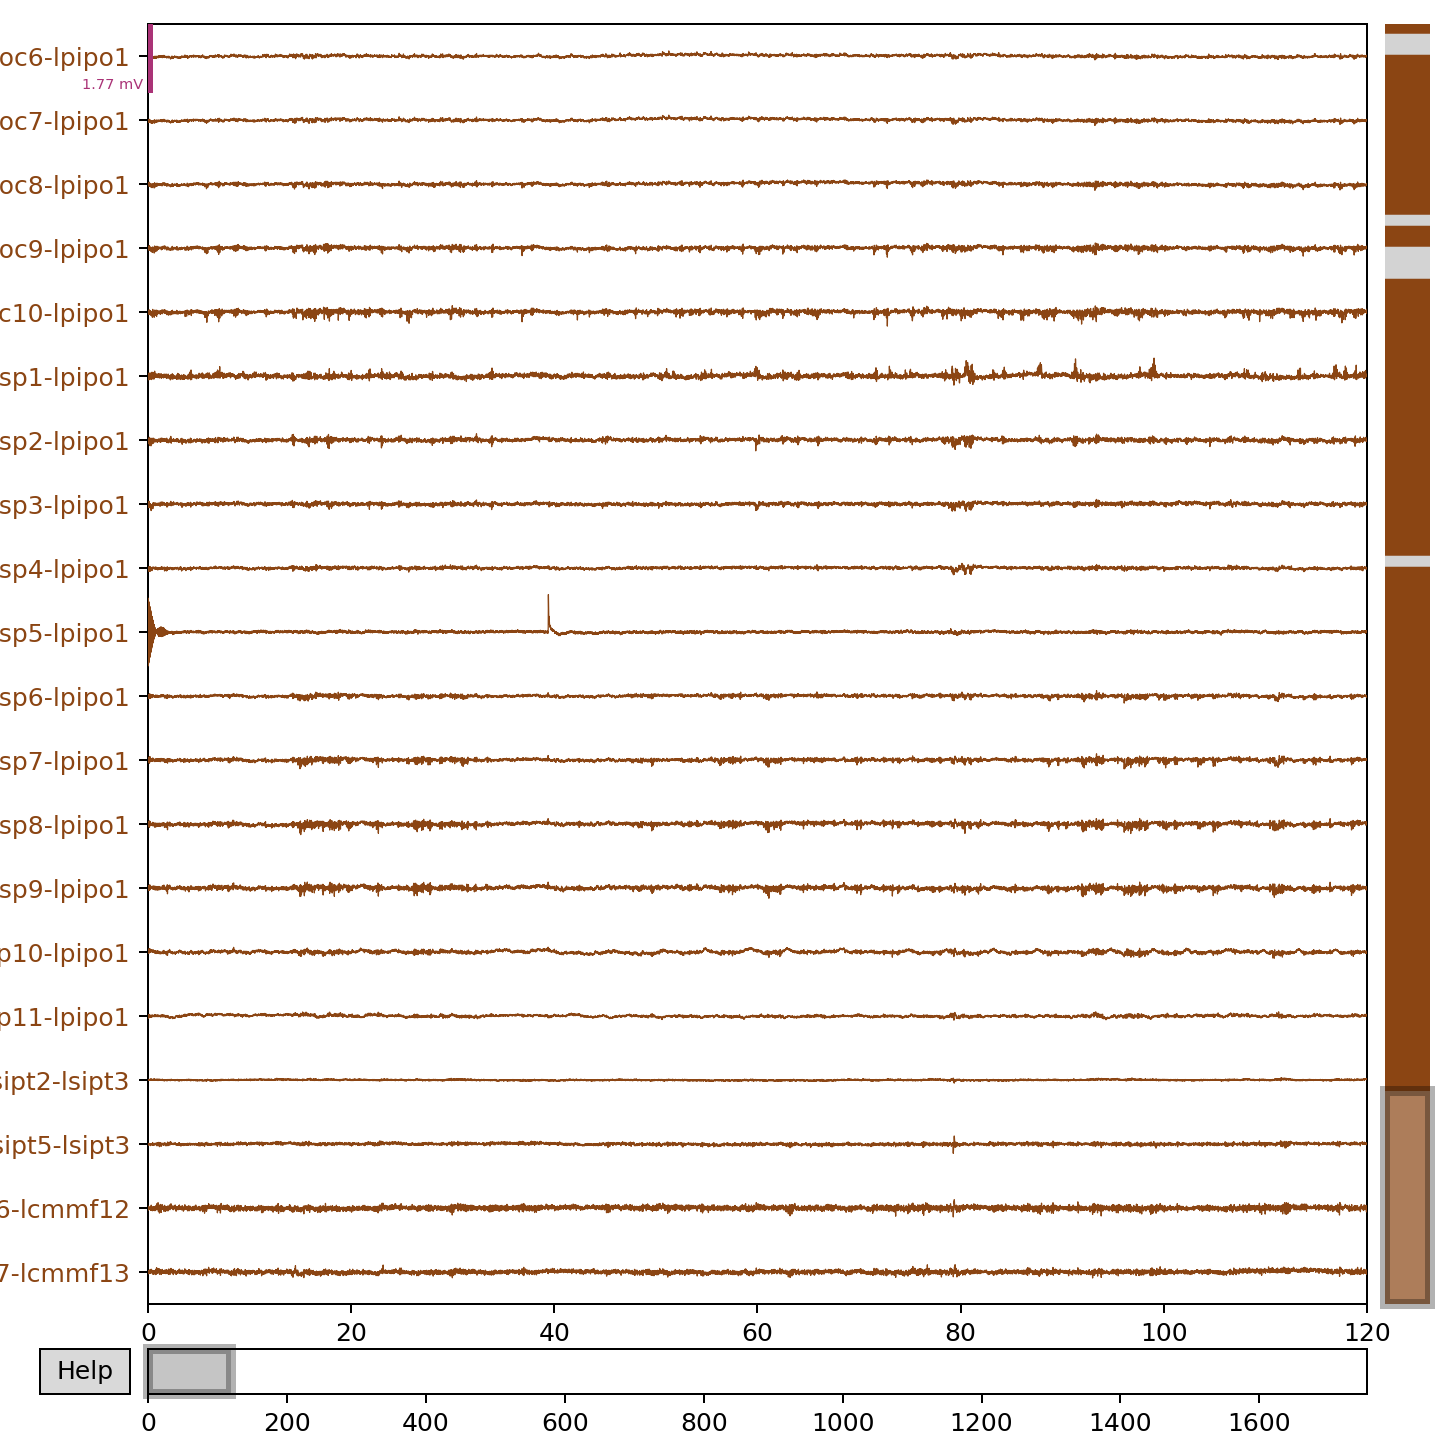

<IPython.core.display.Javascript object>


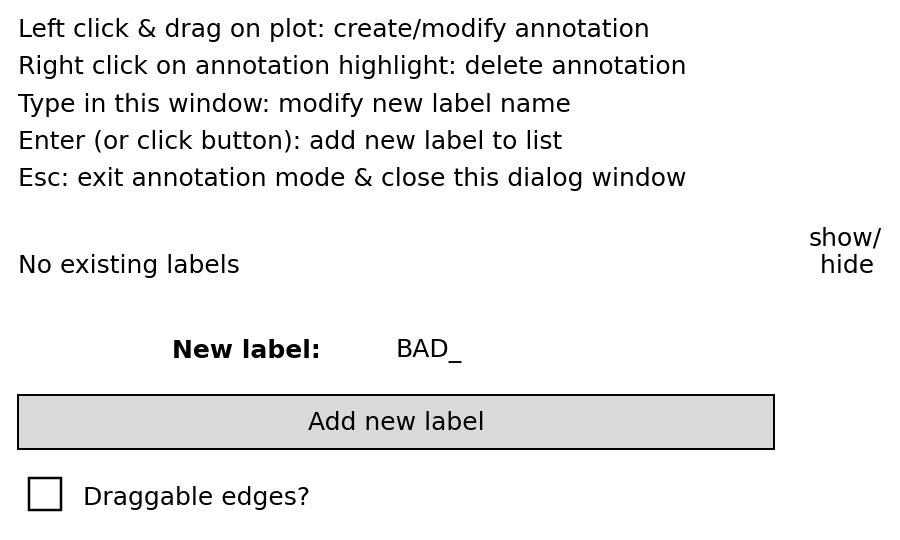

In [31]:
# double check before saving
%matplotlib notebook
fig = mne_data_wm_reref.plot(start=0, duration=120, n_channels=20, scalings=mne_data_wm_reref._data.max()/10) #
fig.fake_keypress('a')

In [32]:
mne_data_wm_reref.info['bads'] # will print the one's we do not want TFRs for. 

['lacas11',
 'lacas12',
 'lhpit12',
 'lprecuoc11',
 'lprecuoc12',
 'lprecusp12',
 'lhpit3-lsipt1']

In [33]:
# Save out the re-referenced data:
mne_data_wm_reref.save(f'{save_dir}/wm_ref_ieeg.fif', overwrite=True)

Writing /Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/wm_ref_ieeg.fif
    Writing channel names to FIF truncated to 15 characters with remapping
Closing /Users/christinamaher/Desktop/fellowship_data/MS030/Ephys/wm_ref_ieeg.fif
[done]
